In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from scipy.integrate import solve_ivp

class AllenCahn:
    """
    An implementation of the Allen-Cahn equation in two dimensions, using the method
    of lines and explicit finite differences

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        kappa (float): reaction rate
        d (float): diffusion coefficient
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction

    """

    def __init__(self, nx, ny, kappa=1.0, d=1.0, Lx=1.0, Ly=1.0):
        self.nx = nx
        self.ny = ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.d = d
        self.kappa = kappa
       
    def _laplace(self, grid):
        """
        Apply the two-dimensional Laplace operator to a square array
        """
        padded_grid = np.vstack((grid[0], grid, grid[-1]))
        padded_grid = np.hstack((padded_grid[:, 0].reshape((np.shape(padded_grid)[0], 1))
                                 , padded_grid, padded_grid[:, -1].reshape((np.shape(padded_grid)[0], 1))))
        
        return (padded_grid[1:-1][:, 0:-2] + padded_grid[1:-1][:, 2:] + padded_grid[2:][:,1:-1] + padded_grid[:-2][:,1:-1]
                - 4*padded_grid[1:-1][:,1:-1])/(self.dx*self.dy)

    def _reaction(self, y):
        """
        Bistable reaction term
        """
        return y*(1-y**2)

    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        y = y.reshape((self.nx, self.ny))
        y = self.d*self._laplace(y) + self.kappa*self._reaction(y)
        return y.flatten()

    def solve(self, y0, t_min, t_max, nt):
        """
        Solve the heat equation using the odeint solver

        **kwargs are passed to scipy.integrate.solve_ivp
        """
        out = solve_ivp(self.rhs, (t_min, t_max), y0.flatten(), t_eval=np.linspace(t_min, t_max, nt), method="DOP853")
        sol = out.y.T
        tpts =  out.t
        return tpts, sol.reshape((nt, self.ny, self.nx))





### Test and use your code
You don't need to write any code below, these cells are just to confirm that everything is working and to play with your implementation

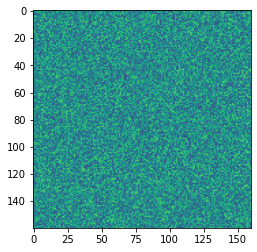

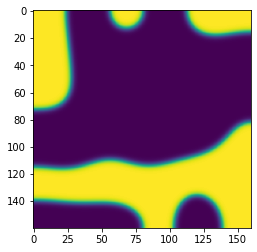

In [23]:
# import one of William's solutions
#from solutions.allencahn_spectral import AllenCahn
#from solutions.allencahn import AllenCahn

## Run an example simulation and plot the before and after
np.random.seed(0)
ic = np.random.random((160, 160)) - 0.5
model = AllenCahn(*ic.shape, kappa=1e1, d=1e-3)
tpts, sol = model.solve(ic, 0, 8, 400)


plt.figure()
plt.imshow(sol[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol[-1], vmin=-1, vmax=1)

**Solving for $\kappa$ = 0**
- $D = 10^{-3}$
- As expected, this should result in a purely diffusive system, with no-ordering as time evolves
- I am initializing an ordered state, taken from the final state of the previous solution

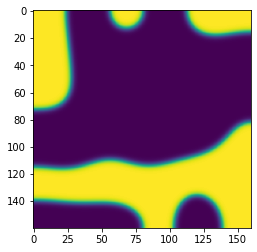

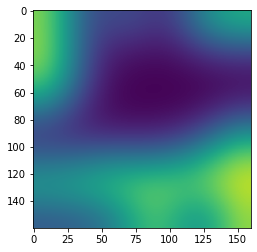

In [24]:
ic = sol[-1]
model = AllenCahn(*ic.shape, kappa=0, d=1e-3)
tpts, sol2 = model.solve(ic, 0, 8, 400)


plt.figure()
plt.imshow(sol2[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol2[-1], vmin=-1, vmax=1)

**As D increases, the system becomes more homogeneous after the same amount of time**

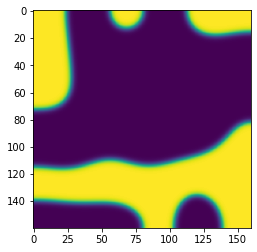

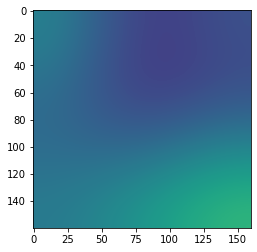

In [28]:
ic = sol[-1]
model = AllenCahn(*ic.shape, kappa=0, d=5e-3)
tpts, sol2 = model.solve(ic, 0, 8, 400)


plt.figure()
plt.imshow(sol2[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol2[-1], vmin=-1, vmax=1)

**If D = 0 and $\kappa \neq 0$, then the system evolves to a locally ordered state with no diffusion to surroundings**

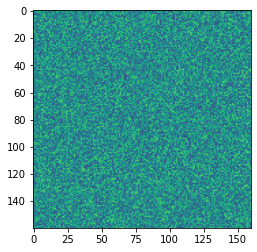

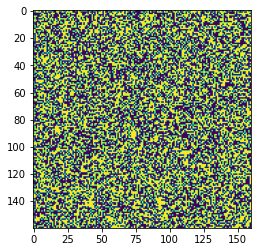

In [31]:
np.random.seed(0)
ic = np.random.random((160, 160)) - 0.5
model = AllenCahn(*ic.shape, kappa=1e1, d=0)
tpts, sol4 = model.solve(ic, 0, 16, 400)


plt.figure()
plt.imshow(sol4[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol4[-1], vmin=-1, vmax=1)

**Gaussian Blur**
- The time dependent part of the solution to the heat equation is Gaussian. So, it makes sense that solving for $\kappa = 0$ results in a solution that is equivalent to applying N Gaussian filters, where N is the number of time steps.
- See below the solutions for $\kappa = 0$ after different time steps

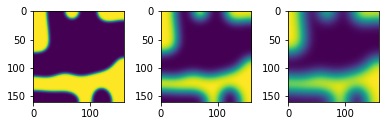

In [42]:
plt.subplot(1, 3, 1)
plt.imshow(sol2[0], vmin=-1, vmax=1, aspect=1)
plt.subplot(1, 3, 2)
plt.imshow(sol2[10], vmin=-1, vmax=1, aspect=1)
plt.subplot(1, 3, 3)
plt.imshow(sol2[20], vmin=-1, vmax=1, aspect=1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

In [49]:
ic = sol[-350]
model = AllenCahn(*ic.shape, kappa=1e1, d=0)
tpts, sol2 = model.solve(ic, 0, 8, 400)

**Sharpening**
- For $D = 0$, the reaction term mimics 'sharpening' in image processing, see example below

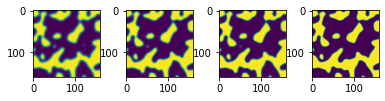

In [54]:
plt.subplot(1, 4, 1)
plt.imshow(sol2[0], vmin=-1, vmax=1, aspect=1)
plt.subplot(1, 4, 2)
plt.imshow(sol2[2], vmin=-1, vmax=1, aspect=1)
plt.subplot(1, 4, 3)
plt.imshow(sol2[4], vmin=-1, vmax=1, aspect=1)
plt.subplot(1, 4, 4)
plt.imshow(sol2[8], vmin=-1, vmax=1, aspect=1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()